# Import Library & View Hardware Details

In [ ]:
!nvidia-smi

Fri Dec 22 18:20:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Get Data

In [ ]:
start_time = datetime.now()

In [ ]:
!gdown 1zXddxYLrxohFmF5pSoVYH1bSwNAZKn8x
!gdown 1U8MP2FwaoI7hDQLp7Ob8D1SYDP_tuK30

Downloading...
From: https://drive.google.com/uc?id=1zXddxYLrxohFmF5pSoVYH1bSwNAZKn8x
To: /content/data.json
100% 3.81M/3.81M [00:00<00:00, 149MB/s]
Downloading...
From: https://drive.google.com/uc?id=1U8MP2FwaoI7hDQLp7Ob8D1SYDP_tuK30
To: /content/custom_stopwords.txt
100% 254/254 [00:00<00:00, 1.28MB/s]


In [ ]:
file_name = 'data.json'

with open(file_name, 'r') as file:
    data = json.load(file)

In [ ]:
df = pd.DataFrame(data)

df.head()

,title,url,publisher,cited,year,quartile
0,Genetic Diversity of Gorontalo Local Cattle Ba...,https://www.scopus.com/record/display.uri?eid=...,Advances in Animal and Veterinary Sciences,0,2023,Q3 Journal
1,Consumers’ Preference and Future Consideration...,https://www.scopus.com/record/display.uri?eid=...,Agris On-line Papers in Economics and Informatics,0,2023,Q2 Journal
2,A meta-analysis of the effects of clay mineral...,https://www.scopus.com/record/display.uri?eid=...,Poultry Science,7,2023,Q1 Journal
3,Identification and Analysis of Geotourism Pote...,https://www.scopus.com/record/display.uri?eid=...,AIP Conference Proceedings,1,2023,Q4 Journal
4,Epipsammic Diatom Cocconesis sp. as New Bioero...,https://www.scopus.com/record/display.uri?eid=...,Jurnal Ilmiah Perikanan dan Kelautan,0,2023,Q4 Journal


In [ ]:
df = df[['title','publisher']]

df

,title,publisher
0,Genetic Diversity of Gorontalo Local Cattle Ba...,Advances in Animal and Veterinary Sciences
1,Consumers’ Preference and Future Consideration...,Agris On-line Papers in Economics and Informatics
2,A meta-analysis of the effects of clay mineral...,Poultry Science
3,Identification and Analysis of Geotourism Pote...,AIP Conference Proceedings
4,Epipsammic Diatom Cocconesis sp. as New Bioero...,Jurnal Ilmiah Perikanan dan Kelautan
...,...,...
11451,Bifidobacterium longum Administration Diminish...,Journal of Inflammation Research
11452,Ascorbic Acid vs Calcitriol in Influencing Mon...,Vascular Health and Risk Management
11453,The Potency of Cowpea (Vigna unguiculata) as A...,AIP Conference Proceedings
11454,Effect of chemical treatment on the physical a...,Results in Engineering


In [ ]:
titles = df['title']
publishers = df['publisher']

combined_features = [title + " " + publisher for title, publisher in zip(titles, publishers)]

df_com = pd.DataFrame(combined_features)

df_com

,0
0,Genetic Diversity of Gorontalo Local Cattle Ba...
1,Consumers’ Preference and Future Consideration...
2,A meta-analysis of the effects of clay mineral...
3,Identification and Analysis of Geotourism Pote...
4,Epipsammic Diatom Cocconesis sp. as New Bioero...
...,...
11451,Bifidobacterium longum Administration Diminish...
11452,Ascorbic Acid vs Calcitriol in Influencing Mon...
11453,The Potency of Cowpea (Vigna unguiculata) as A...
11454,Effect of chemical treatment on the physical a...


# Preprocessing

In [ ]:
def preprocess_text(input_text):
    tokens = word_tokenize(input_text.lower())

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.isalnum() and any(c.isalpha() for c in token) and token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

In [ ]:
df_com[0] = df_com[0].apply(preprocess_text)

df_com

,0
0,genetic diversity gorontalo local cattle based...
1,consumer preference future consideration towar...
2,effect clay mineral supplementation alkaline p...
3,identification analysis geotourism potential p...
4,epipsammic diatom cocconesis sp new bioeroder ...
...,...
11451,bifidobacterium longum administration diminish...
11452,ascorbic acid v calcitriol influencing monocyt...
11453,potency cowpea vigna unguiculata antioxidant a...
11454,effect chemical treatment physical thermal sta...


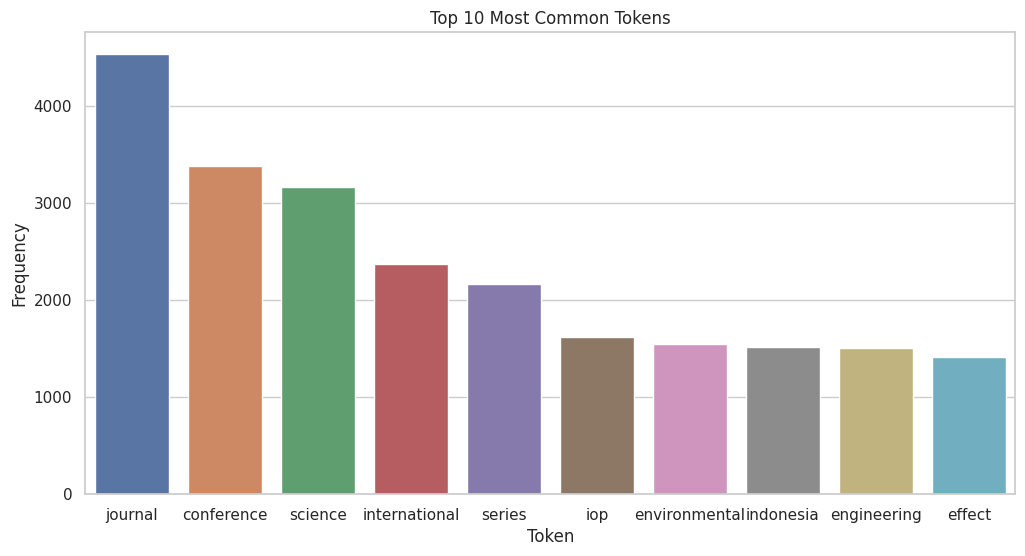

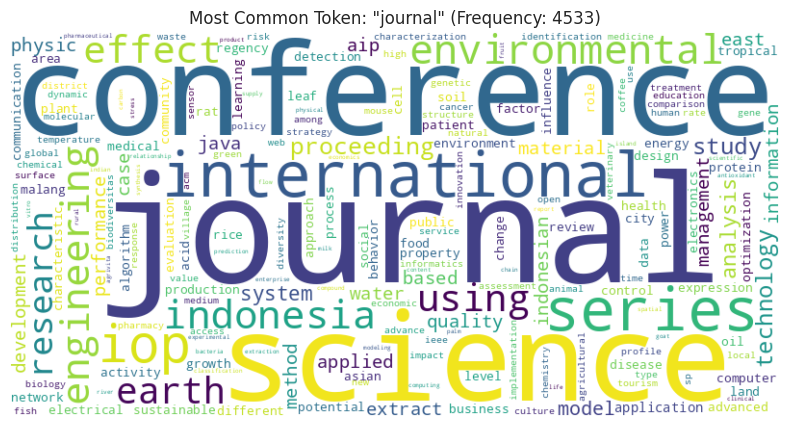

In [ ]:
documents = df_com[0].tolist()

all_tokens = [token for document in documents for token in word_tokenize(document.lower())]

freq_dist = FreqDist(all_tokens)

top_tokens = dict(freq_dist.most_common(10))

data = pd.DataFrame({'Token': list(top_tokens.keys()), 'Frequency': list(top_tokens.values())})

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='Token', y='Frequency', data=data)
plt.title('Top 10 Most Common Tokens')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Most Common Token: "{data["Token"].iloc[0]}" (Frequency: {data["Frequency"].iloc[0]})')
plt.show()

# Functions

In [ ]:
def calculate_tfidf_weights(dataframe):
    corpus = dataframe[0].astype(str).tolist()

    vectorizer = TfidfVectorizer()

    tfidf_matrix = vectorizer.fit_transform(corpus)

    feature_names = vectorizer.get_feature_names_out()

    num_samples, num_features = tfidf_matrix.shape

    tfidf_weights_array = np.zeros((num_samples, num_features))

    for i in range(num_samples):
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        tfidf_weights_array[i, feature_index] = tfidf_matrix[i, feature_index].toarray()

    return tfidf_weights_array

In [ ]:
def kmean(epoch=1, cluster=2, data=None, tuning=False, threshold=None):
    centroid_indices = np.random.choice(np.arange(len(data)), size=cluster, replace=False)
    centroids = data[centroid_indices]

    prev_silhouette = -float('inf')

    for e in range(epoch):
        similarities = cosine_similarity(data, centroids)
        clustered = np.argmax(similarities, axis=1)
        new_centroids = np.array([np.mean(data[clustered == i], axis=0) for i in range(cluster)])
        centroids = new_centroids

        if tuning is False:
            print("Epoch", e+1)
            print("New centroids:")
            for c in centroids:
                print(c)
            print('')

        if threshold is not None:
            curr_silhouette = silhouette_score(data, clustered)

            if curr_silhouette - prev_silhouette < threshold:
                print("Thresholding Condition Met")
                break
            else:
                prev_silhouette = curr_silhouette

    return centroids, clustered

In [ ]:
def elbow_method(X, max_cluster, max_epoch=5, tuning=False):
    distortions = []

    for num_cluster in range(1, max_cluster + 1):
        _, labels = kmean(epoch=max_epoch, cluster=num_cluster, data=X, tuning=True)
        centroids = np.array([np.mean(X[labels == i], axis=0) for i in range(num_cluster)])
        distortions.append(sum([np.linalg.norm(x - centroids[labels[i]]) ** 2 for i, x in enumerate(X)]))

    if(tuning==False):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, max_cluster + 1), distortions, 'bx-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Distortion')
        plt.title('Elbow Method for kmean Clustering')
        plt.show()

    elbow = np.diff(distortions, 2)
    best_k = -1
    max_val = -float('inf')

    for i, val in enumerate(elbow):
        if val > max_val:
            max_val = val
            best_k = i + 2

    return best_k

In [ ]:
def selector_cstm(data):
    tmp_data = data.copy()

    with open('custom_stopwords.txt', 'r') as file:
        stopwords_list = file.read().splitlines()

    cstm_words = ' '.join(stopwords_list).split()

    for token in cstm_words:
        tmp_data[0] = tmp_data[0].str.replace(token, '', case=False)

    weighted_data = calculate_tfidf_weights(tmp_data)

    n_cluster = elbow_method(X=weighted_data, max_cluster=10, tuning=True)

    filtered_score = silhouette_score(weighted_data, kmean(epoch=5, cluster=n_cluster, data=weighted_data, tuning=True)[1])

    print(f"Silhouette Score with Custom words removed:", filtered_score)

    data = weighted_data

    return data, filtered_score

In [ ]:
def selector_top(data):

    top_words_to_remove = [0, 10, 20, 50]

    max_silhouette = float('-inf')
    cluster_count = 0
    remove_words = 0

    for num_words in top_words_to_remove:
        tmp_data = data.copy()
        words_to_remove = dict(freq_dist.most_common(num_words))

        for token in words_to_remove:
            data[0] = data[0].str.replace(token, '', case=False)

        weighted_data = calculate_tfidf_weights(data)

        n_cluster = elbow_method(X=weighted_data, max_cluster=10, tuning=True)

        filtered_score = silhouette_score(weighted_data, kmean(epoch=5, cluster=n_cluster, data=weighted_data, tuning=True)[1])

        print(f"Silhouette Score with {num_words} words removed:", filtered_score)

        if(filtered_score > max_silhouette):
            max_silhouette = filtered_score
            remove_words = num_words
            cluster_count = n_cluster

    words_to_remove = dict(freq_dist.most_common(remove_words))

    for token in words_to_remove:
        data[0] = data[0].str.replace(token, '', case=False)

    data = calculate_tfidf_weights(data)

    score = silhouette_score(data, kmean(epoch=5, cluster=cluster_count, data=data, tuning=True)[1])

    return data, score

# Words Selection & Finding Optimal Cluster

In [ ]:
data, score = selector_top(df_com.copy())

cstm_data, cstm_score = selector_cstm(df_com.copy())

if(score < cstm_score):
  data = cstm_data

Silhouette Score with 0 words removed: 0.00633226494659895
Silhouette Score with 10 words removed: 0.004244672862789839
Silhouette Score with 20 words removed: 0.001554029267674149
Silhouette Score with 50 words removed: 0.0032336892849061417
Silhouette Score with Custom words removed: 0.004917234438090232


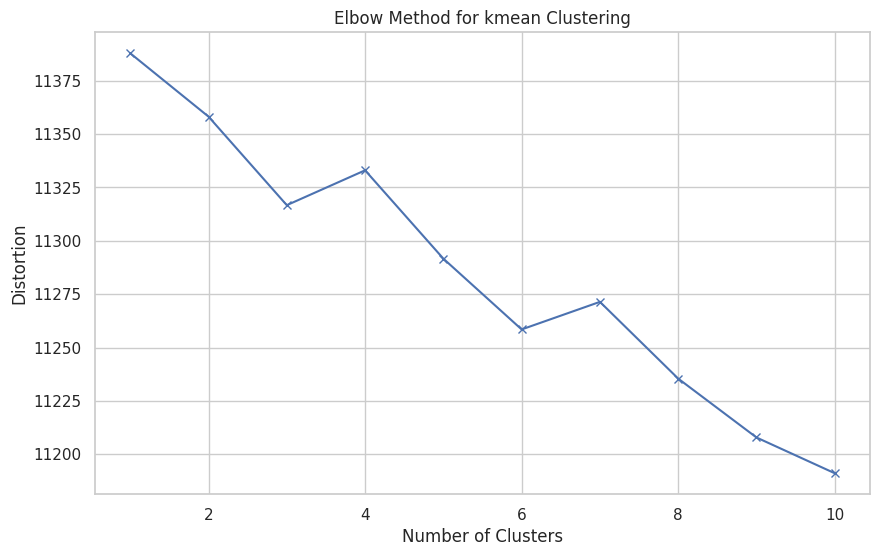

Cluster Optimal :  3


In [ ]:
num_cluster = elbow_method(X=data, max_cluster=10)
print("Cluster Optimal : ", num_cluster)

# Clustering

In [ ]:
%%time

centroids, clustered = kmean(data=data, epoch=20, cluster=num_cluster, threshold=0.0001)

Epoch 1
New centroids:
[2.34247623e-04 9.40177961e-05 4.22342532e-04 ... 7.02723591e-05
 5.94191374e-05 1.09860710e-04]
[0. 0. 0. ... 0. 0. 0.]
[0.00250845 0.         0.0018022  ... 0.         0.         0.        ]

Epoch 2
New centroids:
[2.08586489e-04 0.00000000e+00 2.25562071e-04 ... 7.29464852e-05
 6.16802578e-05 1.14041320e-04]
[0. 0. 0. ... 0. 0. 0.]
[0.00241705 0.00022647 0.00217283 ... 0.         0.         0.        ]

Epoch 3
New centroids:
[6.25206440e-05 0.00000000e+00 2.29122877e-04 ... 7.40980452e-05
 6.26539650e-05 1.15841619e-04]
[0. 0. 0. ... 0. 0. 0.]
[0.00261796 0.00021495 0.00206231 ... 0.         0.         0.        ]

Epoch 4
New centroids:
[0.00000000e+00 0.00000000e+00 1.12924946e-04 ... 7.42404361e-05
 6.27743644e-05 1.16064226e-04]
[0. 0. 0. ... 0. 0. 0.]
[0.00272131 0.00021244 0.00228765 ... 0.         0.         0.        ]

Epoch 5
New centroids:
[0.00000000e+00 0.00000000e+00 1.12841545e-04 ... 7.41856057e-05
 6.27280022e-05 1.15978507e-04]
[0. 0. 0. ..

# Visualization & Cluster Sample

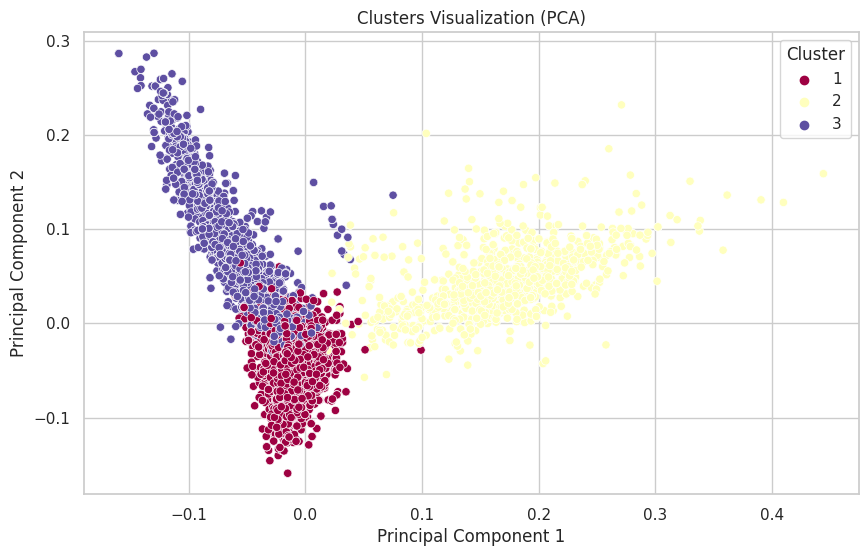

Silhouette Score :  0.0046375652737991315


In [ ]:
clustered+=1

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

df_visualize = pd.DataFrame({'PC1': pca_result[:, 0], 'PC2': pca_result[:, 1], 'Cluster': clustered})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_visualize, palette='Spectral', legend='full')
plt.title('Clusters Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
print('Silhouette Score : ', silhouette_score(data, clustered))

In [ ]:
result_df = pd.concat([df, pd.DataFrame({'Cluster': clustered})], axis=1).sort_values(by='Cluster')

grouped_df = result_df.groupby('Cluster')

sampled_rows_df = pd.DataFrame()

for group, data in grouped_df:
    sampled_rows_df = pd.concat([sampled_rows_df, data.sample(n=3, random_state=42)])

sampled_rows_df

,title,publisher,Cluster
1636,Genetic Variant of C-5434T REN Enhancer on Ser...,International Journal of Hypertension,1
1556,Application of Biourine on growth and yield of...,Agrivita,1
367,Galectin-1 supports survival of naive T cells ...,European Journal of Immunology,1
10602,Quality improvement formulation of salak chili...,IOP Conference Series: Earth and Environmental...,2
9211,Physicochemical and sensory properties of tera...,Microbiological Research,2
8670,Probability of willingness to pay road pricing...,IOP Conference Series: Earth and Environmental...,2
5712,Stability of a stage-structure Rosenzweig-MacA...,IOP Conference Series: Materials Science and E...,3
4346,Stress-strain behavior of steel fiber-reinforc...,Advances in Civil Engineering,3
2416,A generic ontological network for Agri-food ex...,Computers and Electronics in Agriculture,3


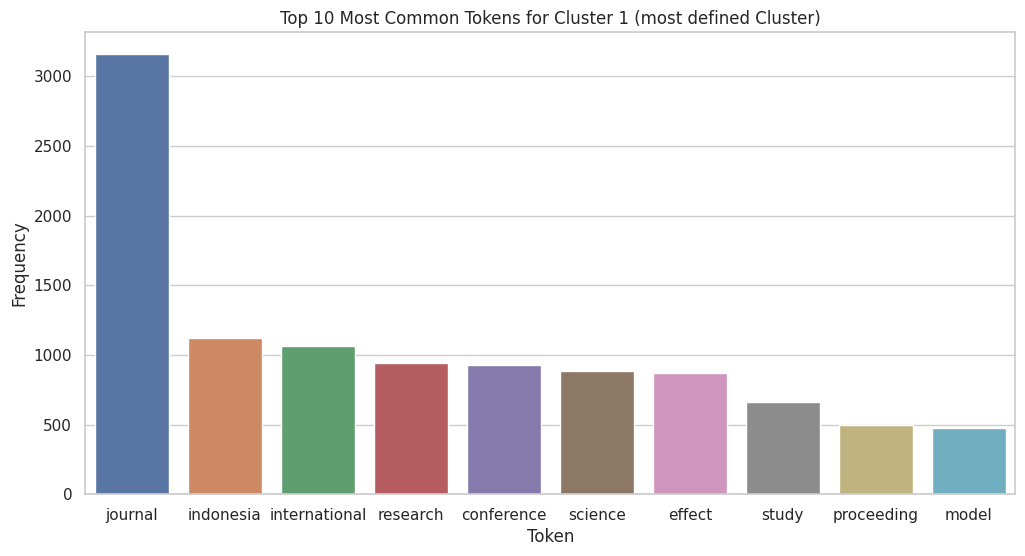

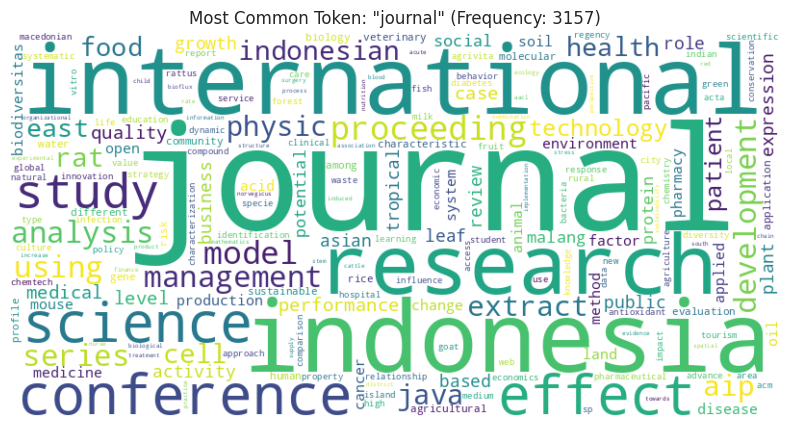

In [ ]:
result_com = pd.concat([df_com, pd.DataFrame({'Cluster': clustered})], axis=1).sort_values(by='Cluster')

result_com = result_com[result_com['Cluster']==1]

documents = result_com[0].tolist()

all_tokens = [token for document in documents for token in word_tokenize(document.lower())]

freq_dist = FreqDist(all_tokens)

top_tokens = dict(freq_dist.most_common(10))

data = pd.DataFrame({'Token': list(top_tokens.keys()), 'Frequency': list(top_tokens.values())})

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='Token', y='Frequency', data=data)
plt.title('Top 10 Most Common Tokens for Cluster 1 (most defined Cluster)')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Most Common Token: "{data["Token"].iloc[0]}" (Frequency: {data["Frequency"].iloc[0]})')
plt.show()

In [ ]:
end_time = datetime.now()
execution_time = end_time - start_time
print(f"Execution time: {execution_time}")

Execution time: 0:22:05.709432
